# Hierarchical Modeling
What models fit the data?

## To-Do:

### In Progress

- show y_pred as part of the median plot
- implement model selection or feature selection

### On Hold
- have median plot alpha scale with hist (requires LineCollection)
- caching (will require me to implement something)

# Setup

### Imports

In [1]:
# Stdlib imports
import os
import shutil

In [2]:
# Calculation imports
import cmdstanpy
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, binned_statistic
from sklearn.metrics import root_mean_squared_error
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

In [3]:
# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

### Parameters

In [4]:
config = {
    "bins": 16,
    "min_bin_percentile": 10,
    "eval_sample_size": 100,
    "nonden_fit_cols": ["references", "year"],
    "cat_col": "stan_field_code",
    "output_dir": "../../analysis_data/stan_fit",
}
config["output_dir"] = f"../../analysis_data/stan_fits/stan_fit_{config["eval_sample_size"]}"

In [5]:
palette = sns.color_palette()

In [6]:
def log_sum_exp(mu):
    """Calculate the log sum of exponentials
    (pulling out the max to maintain) precision.
    """
    mu_max = np.max(mu)

    summation = np.sum(np.exp(mu - mu_max))
    return mu_max + np.log(summation)

In [7]:
def log_ppd(log_p):
    M = len(log_p)
    return -np.log(M) + log_sum_exp(log_p)

### Load data

In [8]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

,density,edginess,references,citations_per_year,is_center,identifier,year,librarian,vectorizer,center,fields_of_study_0
0,1545.550332,0.814415,42,2.250000,False,2e5f3e6c87d1676cdeffc3a2bfbc30b6cd06ed6f,2004,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
1,1846.261870,0.452021,88,4.625000,False,d7b6cd39dd111afa55a3aa418b7b5459db12988d,2012,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
2,1703.520959,0.490212,30,0.882353,False,2d62ec65f95435c72ef750b3cff331382c5dca92,2003,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
3,1901.386693,0.715160,95,8.166667,False,8cebc6e3dcfb543bad48d89112e281a6e11c33c2,2014,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
4,535.472125,0.885892,94,2.090909,False,59730a4bae4dc53f59341b63fd1e63451c589e9f,2009,S2,GPT2,hafenLowredshiftLymanLimit2017,Physics
...,...,...,...,...,...,...,...,...,...,...,...
537685,48.730838,0.658585,41,3.500000,False,806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24,2018,S2,SciBERT,Andre2018,Mathematics
537686,25.107589,0.721374,38,3.200000,False,f40707d1165c22e185c25e6837977177ee380f2c,2015,S2,SciBERT,Andre2018,Mathematics
537687,41.647954,0.646499,11,1.529412,False,10636ee16779a7521001651164acb5c192d4ad7b,2003,S2,SciBERT,Andre2018,Mathematics
537688,35.738649,0.708053,15,2.384615,False,a229f829e0a5362d00e63781f687f40ede991635,2007,S2,SciBERT,Andre2018,Mathematics


In [9]:
# Basic nan handling across all obs
df_all["log_cpy"] = np.log10(df_all["citations_per_year"])
df_all["log_cpy"] = df_all["log_cpy"].replace(-np.inf, np.nan)

/Users/zhafen/miniconda3/envs/cmdstan/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
# Make the field category more useful
df_all["fields_of_study_0"] = df_all["fields_of_study_0"].astype("category")
df_all["stan_field_code"] = df_all["fields_of_study_0"].cat.codes + 1
field_names = df_all["fields_of_study_0"].cat.categories
field_names

Index(['Economics', 'Education', 'Geology', 'Linguistics', 'Materials Science',
       'Mathematics', 'Medicine', 'Philosophy', 'Physics'],
      dtype='object')

In [11]:
vectorizer_names = sorted(df_all["vectorizer"].unique())
vectorizer_names

['BOW', 'GPT2', 'SBERT', 'SciBERT', 'Word2Vec']

## Prep output

In [12]:
# Clear the output dir and recreate
if os.path.exists(config["output_dir"]):
    shutil.rmtree(config["output_dir"])
os.makedirs(config["output_dir"])

# Statistical Modeling

Note to future self: cmdstanpy and cmdstan advertise conda as *the* way to install.
Don't listen to them.
I couldn't get it to compile when I used conda for anything cmdstanpy related.
I downloaded the repo and compiled manually, and used pip for cmdstanpy.

## Train-Test Split

In [13]:
# Pivot to wide format so we can use the same train_test division
# and so we can use multiple densities at once
df_vectorizers = df_all.pivot_table(
    index="identifier", columns="vectorizer", values="density"
)
# For the nonden cols we can take the first because the other values are duplicates
nonden_cols = [
    "log_cpy",
    config["cat_col"],
] + config["nonden_fit_cols"]
df_others = df_all.groupby("identifier")[nonden_cols].first()
df_eval = pd.concat([df_others, df_vectorizers], axis="columns")
df_eval

,log_cpy,stan_field_code,references,year,BOW,GPT2,SBERT,SciBERT,Word2Vec
identifier,,,,,,,,,
000018fc6887cfb1fe43024b111cbfb4e21bac86,0.816610,9,153,2011,20.247480,NaN,NaN,40.709152,48.709426
00012cd6c267ec07566e9298ad5d689462133f98,-0.176091,1,81,2014,16.675367,1821.844826,17.195921,44.223053,46.829885
00015dd1433923dfaecd815a5610b7e02a240bf1,-1.176091,8,5,2005,NaN,NaN,15.303556,NaN,NaN
0001915f25724aabd56021ad216db4657b544bec,0.449093,2,15,2004,15.214642,1474.294829,15.101694,38.331719,36.408183
00019656527337df9943eb8fd5fe10035c216630,0.896251,7,38,2012,NaN,1824.667374,19.787877,NaN,NaN
...,...,...,...,...,...,...,...,...,...
fffd040a476ea5d68014a0c2d29c132bcfa5c281,0.753328,8,39,2014,16.932139,1357.686408,15.175140,34.163358,42.351464
fffdae38cfe952ec7fc4da420d8ad26a06384d9f,-0.447158,1,21,2006,NaN,NaN,17.679814,NaN,NaN
ffff5e6feb617a8cbc7867f2ef0d3422e6107697,0.946125,7,43,2002,13.273726,1656.083989,15.323810,29.493443,39.875730


In [14]:
# Drop all columns where log_cpy is na
df_eval = df_eval.dropna(subset="log_cpy")

In [15]:
# Prep to apply scaling (normalization by mean and sigma) to help with modelling
scaled_cols = (
    [
        "log_cpy",
    ]
    + config["nonden_fit_cols"]
    + vectorizer_names
)
# Convert any non-float to float so scaling doesn't throw errors
df_eval.loc[:, scaled_cols] = df_eval[scaled_cols].astype('float')
df_eval_copy = df_eval.copy() # Make a copy before modifying

In [16]:
# Global scaling
scaler = StandardScaler()
df_eval.loc[:, scaled_cols] = scaler.fit_transform(df_eval[scaled_cols])

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_18646/3415137217.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.29427405  0.36043231 -0.62528953 ... -0.41776914 -0.13242861
 -0.19727873]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_eval.loc[:, scaled_cols] = scaler.fit_transform(df_eval[scaled_cols])
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_18646/3415137217.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.059374    0.52071293 -1.21954787 ... -1.02618556 -1.7996348
  0.13398831]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_eval.loc[:, scaled_cols] = scaler.fit_transform(df_eval[scaled_cols])


In [17]:
# Apply per-field scaling
scalers = {}
new_cols = [f"{col}_j" for col in scaled_cols]
for code_i, ids_i in df_eval_copy.groupby("stan_field_code").groups.items():
    df_i = df_eval_copy.loc[ids_i]

    # Scale
    scaler_i = StandardScaler()
    df_eval.loc[ids_i, new_cols] = scaler_i.fit_transform(df_i[scaled_cols])
    scalers[code_i] = scaler_i


In [18]:
# Variables for referring to scaled versions of the columns
scaled_nonden_fit_cols = [f"{col}_j" for col in config["nonden_fit_cols"]]
scaled_vectorizer_cols = [f"{vectorizer_i}_j" for vectorizer_i in vectorizer_names]
scaled_fit_cols = scaled_nonden_fit_cols + scaled_vectorizer_cols

In [19]:
# Downsample
if config["eval_sample_size"] is not None:
    df_eval = df_eval.sample(config["eval_sample_size"])

In [20]:
# Train-test split
df_train, df_test = train_test_split(df_eval)

In [21]:
# Save for later analysis
df_train.to_csv(f"{config["output_dir"]}/train_data.csv")
df_test.to_csv(f"{config["output_dir"]}/test_data.csv")

In [22]:
# dictionary to store results in
results_dict = {}

## Base model
The base model is just a normal distribution.

In [23]:
stan_model = "base"
model_name = "base"

In [24]:
# Dict for storing output
output = {}

In [25]:
# Drop na
df_train_i = df_train.dropna(subset=["log_cpy"])
df_test_i = df_train.dropna(subset=["log_cpy"])

In [26]:
# Format data
data = {
    "N": len(df_train_i),
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "y_test": df_test_i["log_cpy"].values,
}

In [27]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [28]:
# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

10:50:19 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/base
10:50:19 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:20 - cmdstanpy - INFO - CmdStan done processing.
10:50:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'base.stan', line 13, column 4 to column 29)
Consider re-running with show_console=True if the above output is unclear!


In [29]:
# Parse output
draws = fit.draws_pd()

In [30]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()

In [31]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [32]:
results_dict[stan_model] = pd.Series(output)

## Linear on one density

In [33]:
stan_model = "reg"

### Fit

In [34]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    model_name = f"{vectorizer_i}"

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])
    df_test_i = df_train.dropna(subset=[vectorizer_i, "log_cpy"])

    # Format data
    data = {
        "N": len(df_train_i),
        "x": df_train_i[vectorizer_i].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[vectorizer_i].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output[f"beta[{vectorizer_i}]"] = draws["beta"].median()
    output["sigma"] = draws["sigma"].median()

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

10:50:20 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/BOW
10:50:20 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:20 - cmdstanpy - INFO - CmdStan done processing.
10:50:20 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!
10:50:21 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/GPT2
10:50:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:21 - cmdstanpy - INFO - CmdStan done processing.
10:50:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


10:50:21 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/SBERT
10:50:21 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:21 - cmdstanpy - INFO - CmdStan done processing.


10:50:22 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/SciBERT
10:50:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:22 - cmdstanpy - INFO - CmdStan done processing.
10:50:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


10:50:22 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/Word2Vec
10:50:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:22 - cmdstanpy - INFO - CmdStan done processing.
10:50:22 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'reg.stan', line 16, column 4 to column 40)
Consider re-running with show_console=True if the above output is unclear!


### Evaluate

In [35]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = vectorizer_names

In [36]:
def medianplot(data, x, y, bins, ax, alpha_min=0.1, alpha_max=1.0):

    x = data[x]
    y = data[y]

    centers = (bins[1:] + bins[:-1]) / 2

    # TODO: Use or remove. Needs a LineCollection to work
    # # Calculate histogram (used for line transparency)
    # hist, _ = np.histogram(x, bins=bins, density=True)
    # hist /= hist.max()
    # alpha = alpha_min + hist * (alpha_max - alpha_min)

    # Calculate running median
    median, bin_edges, bin_number = binned_statistic(
        x, y, statistic=np.nanmedian, bins=bins
    )
    ax.plot(
        centers,
        median,
        color="k",
        # alpha=alpha,
    )

    # Calculate running percentiles
    low, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 16),
        bins=bins,
    )
    high, bin_edges, bin_number = binned_statistic(
        x,
        y,
        statistic=lambda v: np.nanpercentile(v, 84),
        bins=bins,
    )
    ax.fill_between(
        centers,
        low,
        high,
        color="k",
        alpha=0.2,
    )

    ax.set_xlim(bins[0], bins[-1])

In [37]:
left_edge = np.nanpercentile(
    df_eval[vectorizer_names].values.flatten(), config["min_bin_percentile"]
)
right_edge = -left_edge
bins = np.linspace(left_edge, right_edge, config["bins"])

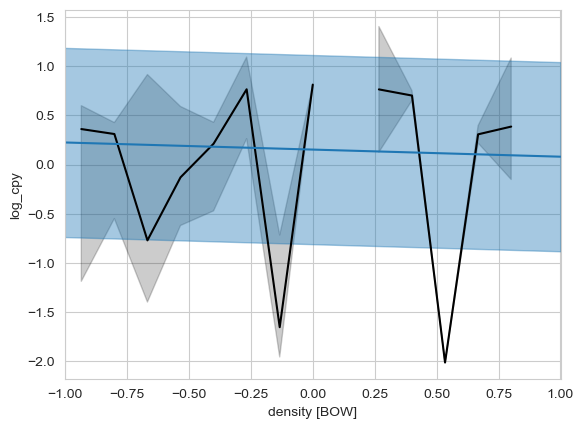

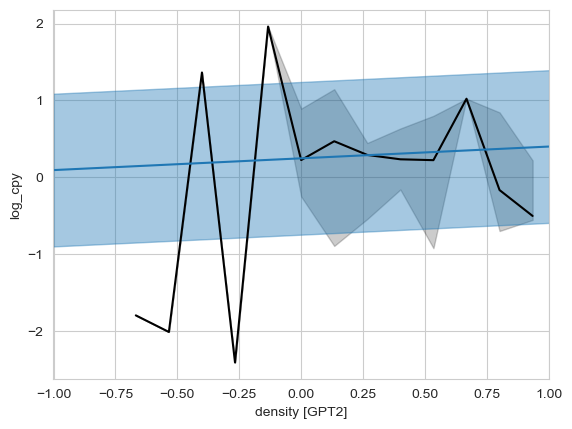

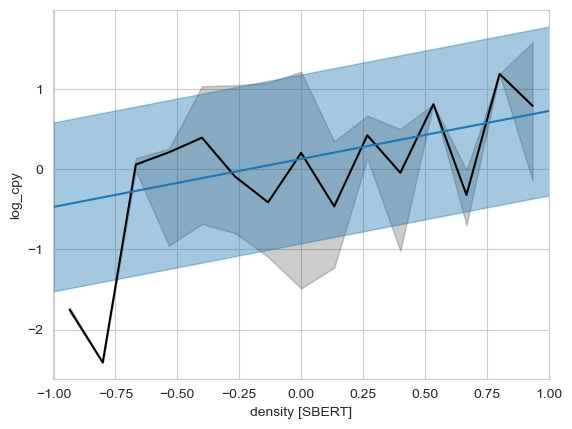

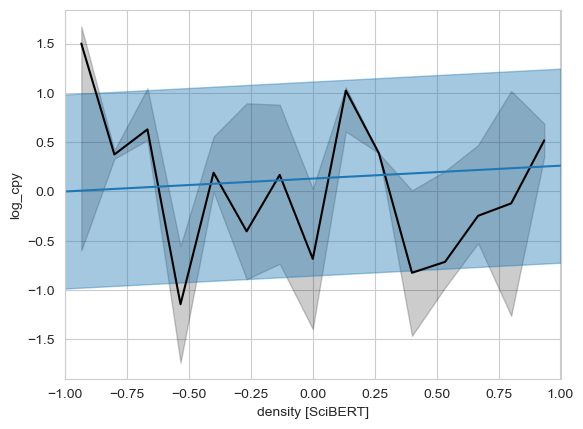

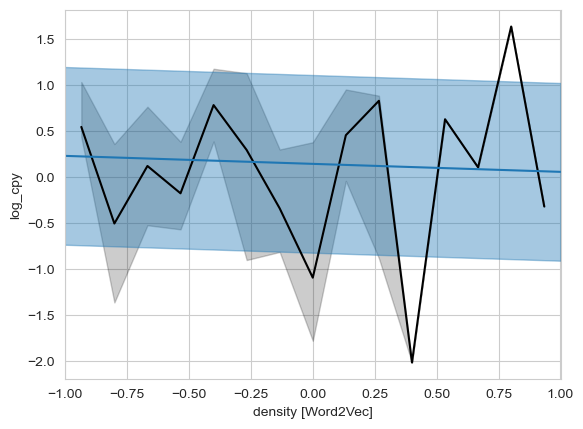

In [38]:
for i, row in output.iterrows():
    fig = plt.figure()
    ax = plt.gca()

    df_plot = df_eval.dropna(subset=[row["vectorizer"], "log_cpy"])

    medianplot(
        data=df_plot,
        x=row["vectorizer"],
        y="log_cpy",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{row["vectorizer"]}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.4,
    )

    ax.set_xlabel(f"density [{row["vectorizer"]}]")
    ax.set_ylabel("log_cpy")

    

## Linear on non-density vars
The next model is a multivate linear regression with no density

In [39]:
stan_model = "multireg"
model_name = "nondens"

In [40]:
fit_cols = config["nonden_fit_cols"]
cols = [
    "log_cpy",
] + fit_cols

In [41]:
# Dict for storing output
output = {}

In [42]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [43]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [44]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [45]:
# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

10:50:25 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/nondens
10:50:25 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:26 - cmdstanpy - INFO - CmdStan done processing.
10:50:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


In [46]:
# Parse output
draws = fit.draws_pd()

In [47]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [48]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [49]:
results_dict[model_name] = pd.Series(output)

## Linear on one density + non-density vars

In [50]:
stan_model = "multireg"

In [51]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(vectorizer_names):
    output = {}

    model_name = f"{vectorizer_i} + nondens"

    # Drop na
    fit_cols = [
        vectorizer_i,
    ] + config["nonden_fit_cols"]
    cols = [
        "log_cpy",
    ] + fit_cols
    df_train_i = df_train.dropna(subset=cols)
    df_test_i = df_train.dropna(subset=cols)

    # Format data
    data = {
        "N": len(df_train_i),
        "K": len(fit_cols),
        "x": df_train_i[fit_cols].values,
        "y": df_train_i["log_cpy"].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[fit_cols].values,
        "y_test": df_test_i["log_cpy"].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    draws = fit.draws_pd()

    # Store parameters
    output["alpha"] = draws["alpha"].median()
    output["sigma"] = draws["sigma"].median()
    beta_cols = [col for col in draws.columns if col[:4] == "beta"]
    betas = draws[beta_cols].median(axis="rows")
    for i, fit_col in enumerate(fit_cols):
        output[f"beta[{fit_col}]"] = betas.iloc[i]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

10:50:26 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/BOW + nondens
10:50:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:26 - cmdstanpy - INFO - CmdStan done processing.
10:50:26 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!
10:50:27 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/GPT2 + nondens
10:50:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:27 - cmdstanpy - INFO - CmdStan done processing.
10:50:27 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/SBERT + nondens
10:50:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:27 - cmdstanpy - INFO - CmdStan done processing.


10:50:27 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/SciBERT + nondens
10:50:27 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:27 - cmdstanpy - INFO - CmdStan done processing.
10:50:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


10:50:28 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/Word2Vec + nondens
10:50:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:28 - cmdstanpy - INFO - CmdStan done processing.
10:50:28 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'multireg.stan', line 31, column 4 to column 45)
Consider re-running with show_console=True if the above output is unclear!


## Linear on all densities + non-density vars
The next model is a multivate linear regression using every variable we have

In [52]:
stan_model = "multireg"
model_name = "dens + nondens"

In [53]:
fit_cols = config["nonden_fit_cols"] + vectorizer_names
cols = [
    "log_cpy",
] + fit_cols

In [54]:
# Dict for storing output
output = {}

In [55]:
# Drop na
df_train_i = df_train[cols].dropna()
df_test_i = df_train[cols].dropna()

In [56]:
# Format data
data = {
    "N": len(df_train_i),
    "K": len(fit_cols),
    "x": df_train_i[fit_cols].values,
    "y": df_train_i["log_cpy"].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[fit_cols].values,
    "y_test": df_test_i["log_cpy"].values,
}

In [57]:
# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

In [58]:
# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

10:50:28 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/dens + nondens
10:50:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:29 - cmdstanpy - INFO - CmdStan done processing.


In [59]:
# Parse output
draws = fit.draws_pd()

In [60]:
# Store parameters
output["alpha"] = draws["alpha"].median()
output["sigma"] = draws["sigma"].median()
beta_cols = [col for col in draws.columns if col[:4] == "beta"]
betas = draws[beta_cols].median(axis="rows")
for i, fit_col in enumerate(fit_cols):
    output[f"beta[{fit_col}]"] = betas.iloc[i]

In [61]:
# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

In [62]:
results_dict[model_name] = pd.Series(output)

## Hierarchical on non-density vars

In [63]:
stan_model = "hreg"

In [64]:
y_col = "log_cpy_j"

### Fit

In [65]:
output = {
    "y_col": y_col,
}

model_name = f"h-nondens"

# Drop na
df_train_i = df_train.dropna()
df_test_i = df_train.dropna()

# Format data
data = {
    "D": len(scaled_nonden_fit_cols),
    "N": len(df_train_i),
    "L": df_train_i[config["cat_col"]].max(),
    "y": df_train_i[y_col].values,
    "ll": df_train_i[config["cat_col"]].values,
    "x": df_train_i[scaled_nonden_fit_cols].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[scaled_nonden_fit_cols].values,
    "y_test": df_test_i[y_col].values,
}

# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

# Parse output
stan_vars = fit.stan_variables()

# Store parameters
for param_key in ["alpha", "sigma"]:
    output[param_key] = np.median(stan_vars[param_key])

# Store per-field and per var betas
betas = np.nanmedian(stan_vars["beta"], axis=0)
mu_betas = np.nanmedian(stan_vars["mu_beta"], axis=0)
mu_sigmas = np.nanmedian(stan_vars["mu_sigma"], axis=0)
for k, fit_col_k in enumerate(scaled_nonden_fit_cols):
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]
    output[f"mu_beta[{fit_col_k}]"] = mu_betas[k]
    output[f"mu_sigma[{fit_col_k}]"] = mu_sigmas[k]

# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

outputs_for_this_model[model_name] = output
results_dict[model_name] = output

10:50:29 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/h-nondens
10:50:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:50:30 - cmdstanpy - INFO - CmdStan done processing.
10:50:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter[2] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
Consider re-running with show_console=True if the above output is unclear!
10:50:30 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 47 divergent transitions (4.7%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 96 divergent transitions (9.6%)
	Chain 4 had 50 divergent transitions (5.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


## Hierarchical linear on one density

In [66]:
stan_model = "hreg"

In [67]:
# Switch to per-field scalings
y_col = "log_cpy_j"

### Fit

In [68]:
# Dictionary to hold modeling output

# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(scaled_vectorizer_cols):
    output = {
        "y_col": y_col,
    }

    model_name = f"h-{vectorizer_i}"

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, y_col])
    df_test_i = df_train.dropna(subset=[vectorizer_i, y_col])

    # Format data
    data = {
        "D": 1,
        "N": len(df_train_i),
        "L": df_train_i[config["cat_col"]].max(),
        "y": df_train_i[y_col].values,
        "ll": df_train_i[config["cat_col"]].values,
        "x": df_train_i[[vectorizer_i]].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[[vectorizer_i]].values,
        "y_test": df_test_i[y_col].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    stan_vars = fit.stan_variables()

    # Store parameters
    output["alpha"] = np.median(stan_vars["alpha"])
    output["sigma"] = np.median(stan_vars["sigma"])

    # Store per-field betas
    betas = np.nanmedian(stan_vars["beta"], axis=0)
    mu_betas = np.nanmedian(stan_vars["mu_beta"], axis=0)
    mu_sigmas = np.nanmedian(stan_vars["mu_sigma"], axis=0)
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{vectorizer_i},{field_name_j}]"] = betas[j][0]
    output[f"mu_beta[{vectorizer_i}]"] = mu_betas[0]
    output[f"mu_sigma[{vectorizer_i}]"] = mu_sigmas[0]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

10:51:34 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/h-BOW_j
10:51:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:51:35 - cmdstanpy - INFO - CmdStan done processing.
10:51:35 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 17 divergent transitions (1.7%)
	Chain 2 had 27 divergent transitions (2.7%)
	Chain 3 had 13 divergent transitions (1.3%)
	Chain 4 had 33 divergent transitions (3.3%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


10:51:35 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/h-GPT2_j
10:51:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:51:36 - cmdstanpy - INFO - CmdStan done processing.
10:51:36 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 7 divergent transitions (0.7%)
	Chain 2 had 7 divergent transitions (0.7%)
	Chain 3 had 47 divergent transitions (4.7%)
	Chain 4 had 85 divergent transitions (8.5%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


10:51:36 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/h-SBERT_j
10:51:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:51:38 - cmdstanpy - INFO - CmdStan done processing.
10:51:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Consider re-running with show_console=True if the above output is unclear!
10:51:38 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 4 divergent transitions (0.4%)
	Chain 2 had 46 divergent transitions (4.6%)
	Chain 3 had 8 divergent transitions (0.8%)
	Chain 4 had 10 divergent transitions (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


10:51:38 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/h-SciBERT_j
10:51:38 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:51:40 - cmdstanpy - INFO - CmdStan done processing.
10:51:40 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter[1] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
Consider re-running with show_console=True if the above output is unclear!
10:51:40 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 19 divergent transitions (1.9%)
	Chain 2 had 8 divergent transitions (0.8%)
	Chain 3 had 3 divergent transitions (0.3%)
	Chain 4 had 6 divergent transitions (0.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


10:51:40 - cmdstanpy - INFO - created output directory: /Users/zhafen/repos/citesim/analysis_data/stan_fits/stan_fit_100/h-Word2Vec_j
10:51:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

10:51:42 - cmdstanpy - INFO - CmdStan done processing.
10:51:42 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'hreg.stan', line 34, column 4 to column 26)
Exception: normal_lpdf: Scale parameter[1] is 0, but must be positive! (in 'hreg.stan', line 26, column 8 to column 46)
Consider re-running with show_console=True if the above output is unclear!
10:51:42 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 22 divergent transitions (2.2%)
	Chain 2 had 14 divergent transitions (1.4%)
	Chain 3 had 21 divergent transitions (2.1%)
	Chain 4 had 16 divergent transitions (1.6%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


### Evaluate

In [72]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = scaled_vectorizer_cols

In [ ]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(scaled_vectorizer_cols)))
mosaic = [[f"{vectorizer_i}_{field_j}" for field_j in field_names] for vectorizer_i in scaled_vectorizer_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, (model_i, row) in enumerate(output.iterrows()):
    vectorizer_i = row["vectorizer"]
    for j, field_j in enumerate(field_names):

        ax_key = f"{vectorizer_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=row["vectorizer"],
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = row["alpha"] + row[f"beta[{row["vectorizer"]},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - row["sigma"],
            ys + row["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{row["vectorizer"]},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)

        

## Hierarchical linear on one density + nondenvars

In [77]:
stan_model = "hreg"

In [78]:
# Switch to per-field scalings
y_col = "log_cpy_j"

### Fit

In [ ]:
# Loop through vectorizers
outputs_for_this_model = {}
for i, vectorizer_i in enumerate(scaled_vectorizer_cols):
    output = {
        "y_col": y_col,
    }

    model_name = f"h-{vectorizer_i} + h-nondens"

    # Drop na
    df_train_i = df_train.dropna(subset=[vectorizer_i, y_col])
    df_test_i = df_train.dropna(subset=[vectorizer_i, y_col])

    fit_cols_i = scaled_nonden_fit_cols + [vectorizer_i, ]

    # Format data
    data = {
        "D": len(fit_cols_i),
        "N": len(df_train_i),
        "L": df_train_i[config["cat_col"]].max(),
        "y": df_train_i[y_col].values,
        "ll": df_train_i[config["cat_col"]].values,
        "x": df_train_i[fit_cols_i].values,
        "N_test": len(df_test_i),
        "x_test": df_test_i[fit_cols_i].values,
        "y_test": df_test_i[y_col].values,
    }

    # Compile model
    model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

    # Fit model
    if not config["output_dir"] is None:
        output_dir = os.path.join(config["output_dir"], model_name)
    fit = model.sample(
        data=data,
        output_dir=output_dir
    )

    # Parse output
    stan_vars = fit.stan_variables()

    # Store parameters
    output["alpha"] = np.median(stan_vars["alpha"])
    output["sigma"] = np.median(stan_vars["sigma"])

    # Store per-field and per var betas
    betas = np.nanmedian(stan_vars["beta"], axis=0)
    mu_betas = np.nanmedian(stan_vars["mu_beta"], axis=0)
    mu_sigmas = np.nanmedian(stan_vars["mu_sigma"], axis=0)
    for k, fit_col_k in enumerate(fit_cols_i):
        for j, field_name_j in enumerate(field_names):
            output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]
        output[f"mu_beta[{fit_col_k}]"] = mu_betas[k]
        output[f"mu_sigma[{fit_col_k}]"] = mu_sigmas[k]

    # Calculate log posterior predictive density
    output["log_ppd"] = log_ppd(draws["log_p"])

    outputs_for_this_model[model_name] = output
    results_dict[model_name] = output

### Evaluate

In [77]:
# Format for showing here
output = pd.DataFrame(outputs_for_this_model).T
output["vectorizer"] = scaled_vectorizer_cols

In [ ]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(scaled_vectorizer_cols)))
mosaic = [[f"{vectorizer_i}_{field_j}" for field_j in field_names] for vectorizer_i in scaled_vectorizer_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, (model_i, row) in enumerate(output.iterrows()):
    vectorizer_i = row["vectorizer"]
    for j, field_j in enumerate(field_names):

        ax_key = f"{vectorizer_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=row["vectorizer"],
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = row["alpha"] + row[f"beta[{row["vectorizer"]},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - row["sigma"],
            ys + row["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{row["vectorizer"]},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)

        

## Hierarchical on two densities + non-density vars

In [ ]:
stan_model = "hreg"

In [ ]:
y_col = "log_cpy_j"

In [ ]:
used_fit_cols = [_ for _ in scaled_fit_cols if _ in ["BOW_j", "SciBERT_j",] + scaled_nonden_fit_cols]
used_fit_cols

### Fit

In [ ]:
output = {
    "y_col": y_col,
}

model_name = f"h-BOW-SciBERT + h-nondens"

# Drop na
df_train_i = df_train.dropna()
df_test_i = df_train.dropna()

# Format data
data = {
    "D": len(used_fit_cols),
    "N": len(df_train_i),
    "L": df_train_i[config["cat_col"]].max(),
    "y": df_train_i[y_col].values,
    "ll": df_train_i[config["cat_col"]].values,
    "x": df_train_i[used_fit_cols].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[used_fit_cols].values,
    "y_test": df_test_i[y_col].values,
}

# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

# Parse output
stan_vars = fit.stan_variables()

# Store parameters
for param_key in ["alpha", "sigma"]:
    output[param_key] = np.median(stan_vars[param_key])

# Store per-field and per var betas
betas = np.nanmedian(stan_vars["beta"], axis=0)
mu_betas = np.nanmedian(stan_vars["mu_beta"], axis=0)
mu_sigmas = np.nanmedian(stan_vars["mu_sigma"], axis=0)
for k, fit_col_k in enumerate(used_fit_cols):
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]
    output[f"mu_beta[{fit_col_k}]"] = mu_betas[k]
    output[f"mu_sigma[{fit_col_k}]"] = mu_sigmas[k]

# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

outputs_for_this_model[model_name] = output
results_dict[model_name] = output

### Evaluate

In [ ]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(vectorizer_names)))
mosaic = [[f"{fit_col_i}_{field_j}" for field_j in field_names] for fit_col_i in scaled_fit_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, fit_col_i in enumerate(used_fit_cols):
    for j, field_j in enumerate(field_names):

        ax_key = f"{fit_col_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=fit_col_i,
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = output["alpha"] + output[f"beta[{fit_col_i},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - output["sigma"],
            ys + output["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{fit_col_i},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)
        

## Hierarchical on all densities + non-density vars

In [113]:
stan_model = "hreg"

In [114]:
y_col = "log_cpy_j"

### Fit

In [ ]:
output = {
    "y_col": y_col,
}

model_name = f"h-dens + h-nondens"

# Drop na
df_train_i = df_train.dropna()
df_test_i = df_train.dropna()

# Format data
data = {
    "D": len(scaled_fit_cols),
    "N": len(df_train_i),
    "L": df_train_i[config["cat_col"]].max(),
    "y": df_train_i[y_col].values,
    "ll": df_train_i[config["cat_col"]].values,
    "x": df_train_i[scaled_fit_cols].values,
    "N_test": len(df_test_i),
    "x_test": df_test_i[scaled_fit_cols].values,
    "y_test": df_test_i[y_col].values,
}

# Compile model
model = cmdstanpy.CmdStanModel(stan_file=f"../stan_models/{stan_model}.stan")

# Fit model
if not config["output_dir"] is None:
    output_dir = os.path.join(config["output_dir"], model_name)
fit = model.sample(
    data=data,
    output_dir=output_dir
)

# Parse output
stan_vars = fit.stan_variables()

# Store parameters
for param_key in ["alpha", "sigma"]:
    output[param_key] = np.median(stan_vars[param_key])

# Store per-field and per var betas
betas = np.nanmedian(stan_vars["beta"], axis=0)
mu_betas = np.nanmedian(stan_vars["mu_beta"], axis=0)
mu_sigmas = np.nanmedian(stan_vars["mu_sigma"], axis=0)
for k, fit_col_k in enumerate(scaled_fit_cols):
    for j, field_name_j in enumerate(field_names):
        output[f"beta[{fit_col_k},{field_names[j]}]"] = betas[j][k]
    output[f"mu_beta[{fit_col_k}]"] = mu_betas[0]
    output[f"mu_sigma[{fit_col_k}]"] = mu_sigmas[0]

# Calculate log posterior predictive density
output["log_ppd"] = log_ppd(draws["log_p"])

outputs_for_this_model[model_name] = output
results_dict[model_name] = output

### Evaluate

In [ ]:
fig = plt.figure(figsize=(6.4 * len(field_names), 4.8 * len(vectorizer_names)))
mosaic = [[f"{fit_col_i}_{field_j}" for field_j in field_names] for fit_col_i in scaled_fit_cols]
ax_dict = fig.subplot_mosaic(mosaic=mosaic)
for i, fit_col_i in enumerate(scaled_fit_cols):
    for j, field_j in enumerate(field_names):

        ax_key = f"{fit_col_i}_{field_j}" 
        ax = ax_dict[ax_key]

        df_plot = df_eval.query(f"stan_field_code == {j+1}")

        medianplot(
            data=df_plot,
            x=fit_col_i,
            y=y_col,
            bins=bins,
            ax=ax,
        )

        # Plot the regression
        xs = bins
        ys = output["alpha"] + output[f"beta[{fit_col_i},{field_j}]"] * xs
        ax.plot(
            xs,
            ys,
            color=palette[0],
        )
        ax.fill_between(
            xs,
            ys - output["sigma"],
            ys + output["sigma"],
            color=palette[0],
            alpha=0.4,
        )

        ax.set_xlabel(f"density [{fit_col_i},{field_j}]")
        ax.set_ylabel(y_col)

        ax.set_ylim(-1.5, 1.5)
        

# Save

In [116]:
results = pd.DataFrame(results_dict).T

In [117]:
# Where we didn't specify a y column we default to log_cpy
results["y_col"] = results["y_col"].fillna("log_cpy")

In [118]:
# Save results
results.to_csv(f"{config["output_dir"]}/results.csv")

In [ ]:
results

# Summarize

## Calculate y_pred

In [120]:
# Get the test x values
x_test = df_test[fit_cols].fillna(0.0).values

In [121]:
# Get the contribution to y_pred from the intercept
alphas = results["alpha"].values.reshape(1, -1)

In [ ]:
# Get the coefficients for regular regression
# and the contribution to y_pred from the regular regression
beta_cols = [f"beta[{fit_col}]" for fit_col in fit_cols]
betas = results[beta_cols].fillna(0.0).values
y_pred_beta = np.matmul(x_test, betas.T)

In [123]:
# Calculate and format y_pred (without the hierarchical reg contribution)
y_pred = alphas + y_pred_beta
y_pred = pd.DataFrame(y_pred, index=df_test.index, columns=results.index)

In [ ]:
# Get the contribution to y_pred from hierarchical regression
n_tot = 0
for i, field_i in enumerate(field_names):
    # Get the x values
    df_test_i = df_test.query(f"stan_field_code == {i + 1}")
    x_test_i = df_test_i[scaled_fit_cols].fillna(0.0).values

    # Get the slopes used for this particular field
    beta_cols_i = [
        f"beta[{fit_col_j},{field_i}]" for fit_col_j in scaled_fit_cols
    ]
    betas_j = results[beta_cols_i].fillna(0.0).values

    # Get y_pred and store it
    y_pred_beta_i = np.matmul(x_test_i, betas_j.T)
    y_pred.loc[df_test_i.index] += y_pred_beta_i

    # Keep track of n_tot as a double check that every observation has a contribution
    # from their primary field
    n_tot += len(y_pred_beta_i)

assert n_tot == len(df_test), "y_pred count doesn't match"

In [ ]:
# Calculate original non-scaled y_pred
y_pred_orig = y_pred.copy()
y_pred_orig = y_pred_orig.set_index([df_test["stan_field_code"], y_pred_orig.index]).sort_index()
for i, field_i in enumerate(field_names):
    y_pred_i = y_pred_orig.loc[i+1].copy()
    for j, model_j in enumerate(results.index):
        if results.loc[model_j,"y_col"] == "log_cpy":
            scaler_used = scaler
        if results.loc[model_j,"y_col"] == "log_cpy_j":
            scaler_used = scalers[i+1]
        y_pred_orig_ij = scaler_used.scale_[0] * y_pred_i[model_j] + scaler_used.mean_[0]
        y_pred_i[model_j] = y_pred_orig_ij
    y_pred_orig.loc[i+1] = y_pred_i.values

# Put the entries back where we found them
y_pred_orig = y_pred_orig.reset_index().set_index("identifier").loc[y_pred.index]
y_pred_orig = y_pred_orig.drop("stan_field_code", axis="columns")
y_pred_orig


In [ ]:
y_pred

## Basic metrics

### Log Posterior Predictive Density

In [ ]:
fig = plt.figure(figsize=(6.4 * len(results) / 10, 4.8))
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["log_ppd"] - results.loc["base", "log_ppd"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")

ax.set_ylabel(r"PPD $\log$ likelihood ratio")

### RMSE

In [128]:
# Calculate rmse
rmse = []
for i, y_col_i in enumerate(results["y_col"]):
    model_i = results.index[i]
    rmse_i = root_mean_squared_error(df_test[y_col_i], y_pred[model_i])
    rmse.append(rmse_i)
results["rmse"] = rmse

In [ ]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    results["rmse"],
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel("rmse")

### Maximum slopes

In [130]:
max_betas = results[beta_cols].max(axis="columns")

In [ ]:
fig = plt.figure()
ax = plt.gca()

x = np.arange(len(results))
ax.scatter(
    x,
    max_betas,
)

ax.set_xticks(x)
ax.set_xticklabels(results.index, rotation=45, ha="right")
ax.set_ylabel(r"max($\beta_i$)")

ax.set_ylim(0, ax.get_ylim()[1])

In [ ]:
# max slopes correlation with rmse
ax = sns.scatterplot(
    results,
    x=max_betas,
    y=1 - results["rmse"],
)
ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.set_xlabel(r"$\max(\beta_i)$")
ax.set_ylabel(r"1 - rmse")

### RMSE vs distance from center

In [ ]:
# Inspect rmse as a function of distance from the center
for model_i in results.index:

    row = results.loc[model_i]

    # Only do models that have a density dependence
    try:
        vectorizer_i = model_i.split("_")[-1]
        assert vectorizer_i in vectorizer_names
    except AssertionError:
        continue

    # Bin and labels setup
    bins = np.linspace(-3, 3, config["bins"])
    centers = 0.5 * (bins[:-1] + bins[1:])
    den_key = f"rho_{vectorizer_i}"
    cut_key = f"{den_key}_bin"
    model_key = f"y_pred_{model_i}"

    # Format data into a new df and group it
    df_test_to_group = pd.DataFrame()
    df_test_to_group[den_key] = df_test[vectorizer_i]
    df_test_to_group[model_key] = y_pred[model_i]
    df_test_to_group[cut_key] = pd.cut(df_test_to_group[den_key], bins)
    df_test_to_group["y_test"] = df_test[row["y_col"]]
    df_grouped = df_test_to_group.groupby(cut_key)

    # Get mean predicted y per bin
    def get_mean_y_pred(df):
        if len(df) == 0:
            return np.nan
        return df[model_key].mean()

    mean_y_pred = df_grouped.apply(get_mean_y_pred)

    # Get rmse
    def get_rmse_of_df(df):
        if len(df) == 0:
            return np.nan
        return root_mean_squared_error(df["y_test"], df[model_key])

    rmse_per_bin = df_grouped.apply(get_rmse_of_df)

    # Also get rmse if y_pred was just the mean
    def get_rmse_from_mean(df):
        if len(df) == 0:
            return np.nan
        y_pred = np.zeros(len(df))  # Since we normalized to 0
        return root_mean_squared_error(df["y_test"], y_pred)

    rmse_from_mean = df_grouped.apply(get_rmse_from_mean)

    # And rmse expected if it was a straight improvement on the mean that scales with
    # slope
    min_rmse = rmse_from_mean - np.abs(centers * row[f"beta[{vectorizer_i}]"])

    # Plot
    fig, ax_dict = plt.subplot_mosaic(
        [
            [
                "hist",
            ],
            [
                "reg",
            ],
            [
                "reg",
            ],
            [
                "rmse",
            ],
            [
                "rmse",
            ],
        ],
        figsize=(8, 12),
    )

    # Hist plot
    ax = ax_dict["hist"]
    sns.histplot(
        x=df_test_to_group[den_key],
        ax=ax,
        bins=bins,
    )
    ax.set_xlim(bins[0], bins[-1])
    ax.set_title(model_i)
    ax.set_xlabel(None)

    # Regression plot
    ax = ax_dict["reg"]

    # Plot the median
    medianplot(
        data=df_test_to_group,
        x=den_key,
        y="y_test",
        bins=bins,
        ax=ax,
    )

    # Plot the regression
    xs = bins
    ys = row["alpha"] + row[f"beta[{vectorizer_i}]"] * xs
    ax.plot(
        xs,
        ys,
        color=palette[0],
    )
    ax.fill_between(
        xs,
        ys - row["sigma"],
        ys + row["sigma"],
        color=palette[0],
        alpha=0.25,
    )

    # Plot what y_pred actually is
    ax = sns.scatterplot(
        x=centers,
        y=mean_y_pred,
        ax=ax,
    )

    ax.set_xlabel(None)
    ax.set_ylabel("log_cpy")

    # RMSE plot
    ax = ax_dict["rmse"]
    ax = sns.scatterplot(
        x=centers,
        y=rmse_per_bin,
        ax=ax,
        label="rmse",
    )
    ax = sns.scatterplot(x=centers, y=rmse_from_mean, ax=ax, label="rmse(y_pred=0)")
    ax = sns.scatterplot(x=centers, y=min_rmse, ax=ax, label="min rmse")
    ax.legend()
    # Center line
    ax.axvline(
        0,
        c="0.2",
        linestyle="--",
    )
    # Global rmse line
    ax.axhline(
        results.loc[model_i, "rmse"],
        c="0.2",
        linestyle="--",
    )

    ax.set_ylabel("rmse")
    ax.set_xlabel(den_key)

    ax.set_xlim(bins[0], bins[-1])
    ax.set_ylim(0, ax.get_ylim()[1])
    fig

The issue is that RMSE is capturing two behaviors: distance from the mean and also width of the distribution.
The width of the distribution largely dominates over the distance from the mean.
So instead we may want a metric that is an evaluation of the distance median.
This might relate to Nathaniel's choice to bin.

## Many metrics

In [134]:
metrics = {
    r"$R^2$": sk_metrics.r2_score,
    "1-MAE": lambda y_true, y_pred: 1 - sk_metrics.mean_absolute_error(y_true, y_pred),
    "1-RMSE": lambda y_true, y_pred: 1
    - sk_metrics.root_mean_squared_error(y_true, y_pred),
    "1-MAPE": lambda y_true, y_pred: 1
    - sk_metrics.mean_absolute_percentage_error(y_true, y_pred),
    "1-MedAE": lambda y_true, y_pred: 1
    - sk_metrics.median_absolute_error(y_true, y_pred),
    "1-MPinL": lambda y_true, y_pred: 1 - sk_metrics.mean_pinball_loss(y_true, y_pred),
    r"$D^2_{pin}$": sk_metrics.d2_pinball_score,
    r"$D^2_{abs}$": sk_metrics.d2_absolute_error_score,
}

In [ ]:
for metric_label, metric_fn in metrics.items():

    # Calculate the metric
    metric = []
    for i, model_i in enumerate(results.index):
        metric_i = metric_fn(df_test[results.loc[model_i, "y_col"]], y_pred[model_i])
        metric.append(metric_i)

    # Plot
    fig = plt.figure(figsize=(6.8 * len(results) / 10, 4.8))
    ax = plt.gca()

    x = np.arange(len(results))
    ax.scatter(
        x,
        metric,
    )

    ax.set_xticks(x)
    ax.set_xticklabels(results.index, rotation=45, ha="right")
    ax.set_ylabel(metric_label)

## Many metrics rescaled
Back in original units

In [ ]:
y_test = df_eval_copy.loc[df_test.index, "log_cpy"]

for metric_label, metric_fn in metrics.items():
    # Calculate the metric
    metric = []
    for i, model_i in enumerate(results.index):
        metric_i = metric_fn(y_test, y_pred_orig[model_i])
        metric.append(metric_i)

    # Plot
    fig = plt.figure(figsize=(6.8 * len(results) / 10, 4.8))
    ax = plt.gca()

    x = np.arange(len(results))
    ax.scatter(
        x,
        metric,
    )

    ax.set_xticks(x)
    ax.set_xticklabels(results.index, rotation=45, ha="right")
    ax.set_ylabel(metric_label)